In [1]:
# Install package for PEP8 verification
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8


Looking in indexes: https://test.pypi.org/simple/


In [1]:
# Import Python libraries
import os
import warnings
import time
import joblib
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
import multiprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

# Library for PEP8 standard
from nbpep8.nbpep8 import pep8

C:\Users\Mohaw\AppData\Local\Temp\ipykernel_2804\1018615925.py:33: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
set_config(display='diagram')


In [ ]:
#Importation data
data = pd.read_csv("StackOverflow_cleaned.csv", sep=";",
                   index_col=0,
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval})
data.head(5)


In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data= data.sample(10000, random_state=1)

In [ ]:
data.to_csv('data-reduite_stack.csv')

In [8]:
data['text'] = data['Title'] + data['Body']

data.drop(['Title', 'Body','Score', 'Tags'], axis=1, inplace=False)
data.head()


,Title,Body,Score,Tags,text
Id,,,,,
26316237,"[cron, execute, node, script]","[want, server, execute, node, script, every, m...",10,[node.js],"[cron, execute, node, script, want, server, ex..."
39052024,"[get, rid, white, strip, top, screen, adjustre...","[keyboard, open, white, strip, appears, top, s...",8,[android],"[get, rid, white, strip, top, screen, adjustre..."
44662417,"[cs, filter, slow, safari, different, order, s...","[seems, like, position, order, make, huge, dif...",10,[css],"[cs, filter, slow, safari, different, order, s..."
25993225,"[uri, gethost, return, null]","[one, returning, one, returning, weird, logic,...",19,[java],"[uri, gethost, return, null, one, returning, o..."
29832037,"[get, script, directory, posix]","[following, code, bash, script, wan, use, posi...",91,[bash],"[get, script, directory, posix, following, cod..."


In [9]:
#Nous avons besoin de traiter des données numériques pour alimenter les modèles de machine learning. Le modèle Bag of Words apprend un vocabulaire à partir de tous les documents, puis modélise chaque document en comptant le nombre de fois où chaque mot apparaît, convertissant donc les données textuelles en données numériques.



In [10]:
# Define X and y
X = data["text"]
y = data["Tags"]

# Initialize the "CountVectorizer" TFIDF for text
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for text: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))


Shape of X for text: (50000, 1474)
Shape of y: (50000, 50)


In [11]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))


X_train shape : (35000, 1474)
X_test shape : (15000, 1474)
y_train shape : (35000, 50)
y_test shape : (15000, 50)


Vu que les matrices sont importantes, Vérifions le nombre de cellules qui ne sont pas à 0 :

In [12]:
full_dense = X_tfidf.todense()
print("text sparsicity: {:.3f} %"\
      .format(((full_dense > 0).sum()/full_dense.size)*100))


text sparsicity: 2.474 %


Nous constatons que cette mesure est meilleure pour la varaible englobant text(Title et Body).

#                                                   # Modèles non supervisés

# Modèle LDA
LDA (Latent Derelicht Analysis) est un modèle probabiliste qui, pour obtenir des affectations de cluster, utilise deux valeurs de probabilité :  
P. Ces valeurs sont calculées sur la base d'une attribution aléatoire initiale, puis le calcul est répété pour chaque mot dans chaque document, pour décider de leur attribution de sujet. Dans cette méthode itérative, ces probabilités sont calculées plusieurs fois, jusqu'à la convergence de l'algorithme.

Nous allons entrainer 1 seul modèle basé sur la variable text en utilisant la librairie spécialisée Gensim. Pour cette partie, nous n'utiliserons pas le preprocessing TFIDF mais des fonctions propres aux méthodes Gensim.

Dans une première étape, le Bag of words est créé ainsi que la matrice de fréquence des termes dans les documents :



In [13]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus
texts = X
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])


[[(0, 1), (1, 5), (2, 1), (3, 2), (4, 1), (5, 2), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 4), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]]


Gensim crée un identifiant unique pour chaque mot du document puis mappe word_id et word_frequency. Exemple : (3,4) ci-dessus indique que word_id 3 apparaît 4 fois dans le document et ainsi de suite.
Les mots les plus fréquents ont ici aussi été filtrés grâce à la fonction filter_extremes réglée à 60% comme pour le Tfidf.

Pour voir quel mot correspond à un identifiant donné, il faut transmettre l'identifiant comme clé du dictionnaire. Exemple : id2word[4] :

In [14]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('believe', 1),
  ('cron', 5),
  ('debug', 1),
  ('directory', 2),
  ('else', 1),
  ('every', 2),
  ('executable', 1),
  ('execute', 5),
  ('executed', 1),
  ('executes', 1),
  ('executing', 1),
  ('expected', 1),
  ('file', 4),
  ('filepaths', 1),
  ('folder', 1),
  ('getting', 1),
  ('hand', 1),
  ('happens', 1),
  ('idea', 1),
  ('like', 1),
  ('line', 1),
  ('log', 1),
  ('look', 1),
  ('looking', 1),
  ('main', 1),
  ('manually', 1),
  ('minute', 2),
  ('node', 2),
  ('nothing', 1),
  ('outside', 1),
  ('perfectly', 1),
  ('picking', 1),
  ('placed', 1),
  ('pretty', 1),
  ('problem', 2),
  ('program', 1),
  ('radio', 1),
  ('relative', 1),
  ('sample', 1),
  ('script', 2),
  ('server', 1),
  ('set', 1),
  ('silence', 1),
  ('somewhere', 1),
  ('sure', 1),
  ('tried', 1),
  ('update', 1),
  ('want', 1),
  ('work', 1)]]

In [15]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                              workers=4)
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model,
                                     texts=texts,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.32801219561261746


In [16]:
!pip install pyLDAvis

In [17]:
#Visualisation des résultats de LDA Gensim sur text avec 20 topics


import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(full_lda_model, corpus, id2word)


C:\Users\Mohaw\AppData\Local\Temp\ipykernel_10256\1474582826.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.066242  0.022382       1        1  13.271353
19     0.096114  0.002721       2        1   9.304620
14     0.015096 -0.082783       3        1   8.741832
10    -0.092034  0.012628       4        1   7.317930
15    -0.014599 -0.026869       5        1   5.848477
2     -0.045707  0.005722       6        1   4.877600
16     0.001222 -0.008299       7        1   4.772261
0     -0.033363  0.011690       8        1   4.552194
8      0.001707  0.011777       9        1   4.497097
7      0.001800 -0.000497      10        1   4.396096
18     0.030415 -0.009914      11        1   4.054896
1     -0.017577  0.002718      12        1   3.663012
4      0.006359  0.012559      13        1   3.433980
9     -0.053181 -0.040399      14        1   3.388477
11    -0.007540  0.010152      15        1   3.329386
17     0.004776  0.030963      16        1   3.275220
12     0.021968 -0.011314      17        1   3.243652
13     0.014539 -0.010216      18        1   3.022536
3      0.009662 -0.015431      19        1   2.672871
5     -0.005900  0.082409      20        1   2.336510, topic_info=         Term          Freq         Total Category  logprob  loglift
132  function  17088.000000  17088.000000  Default  30.0000  30.0000
12       file  23020.000000  23020.000000  Default  29.0000  29.0000
213     error  20845.000000  20845.000000  Default  28.0000  28.0000
206     array  10703.000000  10703.000000  Default  27.0000  27.0000
122      code  32989.000000  32989.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
93        one    318.473013  18009.940212  Topic20  -5.4858  -0.2786
160      need    296.917883  13689.800993  Topic20  -5.5559  -0.0744
472   project    281.580894   8617.335545  Topic20  -5.6089   0.3354
129      data    284.808708  12518.467607  Topic20  -5.5975  -0.0266
337     class    283.151797  15108.382972  Topic20  -5.6034  -0.2205

[1793 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11743     10  0.092972  __thiscall
11743     17  0.836752  __thiscall
12035      3  0.042842    _session
12035      5  0.085684    _session
12035      6  0.814002    _session
...      ...       ...         ...
9804       6  0.064418  zygoteinit
9804       7  0.740805  zygoteinit
9804       8  0.096627  zygoteinit
9804      12  0.032209  zygoteinit
9805       7  0.825623         zza

[10986 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 20, 15, 11, 16, 3, 17, 1, 9, 8, 19, 2, 5, 10, 12, 18, 13, 14, 4, 6])

D'après les résulatas de cette modélisation LDA, il semble très difficile de "nommer" les topics créés car les mots qui les composent sont très variés et sans fil conducteur clairement établi.

### Amélioration du modèle LDA
Cependant, dans l'algoritmes LDA, nous avons fixé arbitrairement à 20 le paramètre num_topics qui représente le nombre de topics à créer. Afin de sélectionner le meilleur nombre de topics pour nos données, nous allons itérer sur une fourchette de nombre de topics et tester le score de cohérence pour chaque modèle :

In [18]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,90,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                             texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))



Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41
Fitting LDA for K = 51
Fitting LDA for K = 61
Fitting LDA for K = 71
Fitting LDA for K = 81


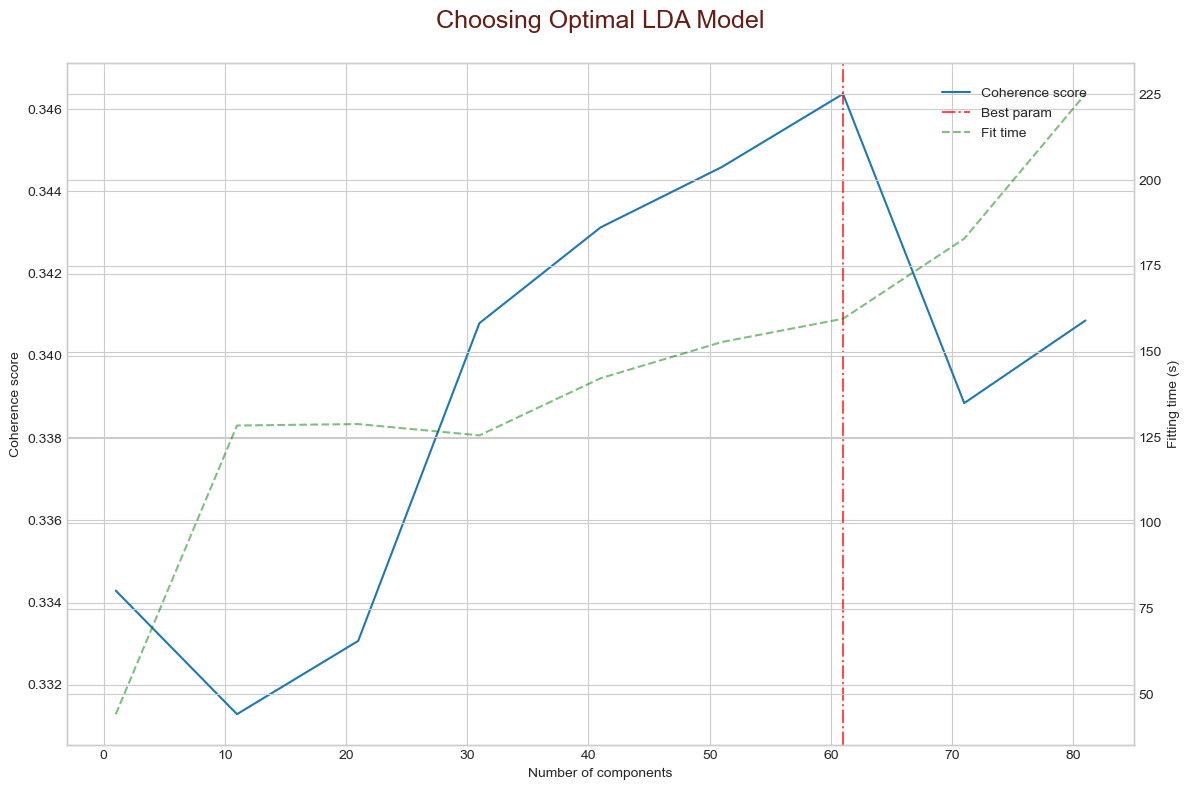

In [19]:
 #Affichons les scores des divers modèle :

# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [20]:
#Testons à présent le modèle avec le meilleur nombre théorique de topics pour l'afficher avec LDAvis :

# Best LDA visualization
# Construire le modèle LDA
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_nb_topics,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=2)
gensimvis.prepare(best_lda_model, corpus, id2word)



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.143527  0.053154       1        1  5.591427
31    -0.152076  0.086365       2        1  3.654532
41     0.027894  0.092151       3        1  3.467086
44     0.069307  0.058756       4        1  3.139208
36     0.135308 -0.020280       5        1  2.873074
...         ...       ...     ...      ...       ...
12    -0.008919  0.007014      57        1  0.686093
1     -0.014534  0.017518      58        1  0.651061
11    -0.022948 -0.020062      59        1  0.600224
0     -0.036769  0.016720      60        1  0.598805
18     0.008791 -0.003824      61        1  0.585087

[61 rows x 5 columns], topic_info=         Term          Freq         Total Category  logprob  loglift
132  function  17740.000000  17740.000000  Default  30.0000  30.0000
12       file  24366.000000  24366.000000  Default  29.0000  29.0000
213     error  22161.000000  22161.000000  Default  28.0000  28.0000
206     array  10165.000000  10165.000000  Default  27.0000  27.0000
337     class  14861.000000  14861.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
54        get    100.987226  22173.171748  Topic61  -5.2497  -0.2505
626       new     76.744182   8963.241223  Topic61  -5.5242   0.3808
348      also     77.708785  12416.090680  Topic61  -5.5117   0.0674
160      need     75.500536  14134.166058  Topic61  -5.5406  -0.0910
77    example     70.590806  12882.639877  Topic61  -5.6078  -0.0656

[4954 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
10843     24  0.934930         ++i
3172       3  0.031519    __init__
3172      52  0.914053    __init__
7809      40  0.089834        _get
7809      53  0.808509        _get
...      ...       ...         ...
2509      48  0.037334        zoom
2509      60  0.021334        zoom
10328      3  0.889711       zxing
9804      10  0.181721  zygoteinit
9804      26  0.757169  zygoteinit

[48616 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 32, 42, 45, 37, 60, 15, 51, 49, 27, 43, 11, 53, 35, 56, 26, 54, 47, 50, 29, 44, 20, 8, 16, 38, 17, 41, 6, 25, 57, 9, 52, 34, 40, 31, 58, 28, 33, 23, 22, 55, 48, 46, 10, 39, 5, 61, 4, 21, 3, 24, 59, 36, 18, 30, 14, 13, 2, 12, 1, 19])

Pour attribuer des Tags à chaque question sur ces modèles non-supervisés, nous allons créer une matrice Topic/Tags en réalisant une multiplication matricielle des matrices Document / Topic et Document / Tags.


In [21]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)


document/tag :  (50000, 50)
document/topic :  (50000, 61)


In [22]:
# Print documents / topic matrix
doc_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,...,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245
1,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.304296,...,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547,0.000547
2,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,0.000256,...,0.000256,0.000256,0.000256,0.000256,0.000256,0.503983,0.000256,0.000256,0.232494,0.000256


In [23]:
#A présent, créons la matrice Topic / Tags grâce aux probabilités obtenues :

# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized)
topic_tag.shape


(61, 50)

In [24]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,6.782308,8.717092,47.804854,4.178565,2.564870,4.019143,2.626081,1.278132,1.162771,13.474581,...,2.967178,2.283094,2.310099,1.122759,1.757496,5.417664,2.849046,1.838411,3.410670,4.472766
1,5.426094,4.850744,38.657712,4.060523,2.480003,13.923979,1.331778,1.073720,1.599171,9.824521,...,1.539817,0.677678,7.034208,4.884774,4.155395,7.743176,1.437195,1.372445,4.243385,4.378267
2,7.497677,3.964808,159.546808,5.423698,2.348072,3.728008,4.070111,1.667762,0.549697,14.197437,...,4.050526,6.251397,2.780340,3.056866,3.747714,11.123796,4.189358,2.095687,3.022928,5.046751
3,12.384237,47.180673,42.107773,3.809520,2.945351,6.976037,2.845539,1.365283,1.545098,22.469724,...,2.845309,2.334482,4.892566,2.728969,4.056475,10.753417,1.352569,1.957060,3.623657,5.600496
4,25.321219,9.857565,33.254284,6.450409,1.583870,6.203341,8.242681,4.982785,2.913500,22.612264,...,6.126146,2.550148,6.080404,6.020705,6.912524,9.180840,3.194537,2.969661,7.325118,2.884491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,26.701018,52.359786,38.186363,11.951698,4.710108,8.163476,7.146435,2.246391,8.588044,54.342497,...,6.160839,1.668959,31.450846,20.957573,8.175937,10.847497,4.763919,2.520821,7.599228,3.006752
57,20.197352,14.275826,26.558514,8.712573,9.131897,10.490334,9.203914,5.813358,64.220320,25.840836,...,4.088599,2.236823,13.672344,6.920946,36.516620,11.456224,4.091340,2.852309,9.657766,3.563438
58,12.990767,2.191067,46.342949,14.096190,7.379318,4.372392,10.488141,4.008307,2.694957,10.516289,...,6.046485,5.373709,11.892364,7.322366,2.665237,7.190868,7.826508,2.786407,8.773515,4.583513
59,38.946026,3.514603,48.688593,15.390269,18.792399,4.944310,46.130860,17.982134,4.788324,9.239945,...,15.478823,10.959761,5.218156,10.448748,4.169977,8.147860,6.481773,8.612136,24.919895,4.017482


In [25]:
#Nous obtenons donc une matrice dont les lignes représentent les Topics créés et les colonnes les Tags associés et leurs distribution. Nous allons donc créer nos prédictions en prenant les
#n
  #premiers tags associés aux topics de chaque document :

y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(5)


,Tags,best_topic,nb_tags,y_true
Id,,,,
26316237,[node.js],24,1,[30]
39052024,[android],14,1,[2]
44662417,[css],56,1,[13]
25993225,[java],60,1,[21]
29832037,[bash],49,1,[8]


In [26]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)

y_results["y_pred"] = list_tag
y_results.head()

,Tags,best_topic,nb_tags,y_true,y_pred
Id,,,,,
26316237,[node.js],24,1,[30],[21]
39052024,[android],14,1,[2],[13]
44662417,[css],56,1,[13],[21]
25993225,[java],60,1,[21],[21]
29832037,[bash],49,1,[8],[21]


Nous allons tester plusieurs métriques sur ce modèle LDA :

Accuracy score :
F1 score :
Jaccard similarity score :
Recall :
Precision :


In [27]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested.

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame
        DataFrame to extend.
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])

    scores = []
    scores.append(metrics.accuracy_score(y_true,
                                         y_pred))
    scores.append(metrics.f1_score(y_pred,
                                   y_true,
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true,
                                        y_pred,
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true,
                                       y_pred,
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true,
                                          y_pred,
                                          average='weighted'))
    temp_df[model] = scores

    return temp_df



In [28]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1

lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [29]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare


C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LDA
Accuracy,0.198800
F1,0.364818
Jaccard,0.162717
Recall,0.314325
Precision,0.300119


On remarque ici que la modélisation non supervisée avec LDA n'est pas adaptée. En effet, le meilleur nombre de topics se situerait à 31, mais l'algorithme ne parvient pas a établir de groupes bien distincts. Un certain nombre de topics sont très regroupés et donc représentés par les mêmes termes.

Nous allons donc tester une seconde modélisation non supervisée.



# Modèle NMF

Le modèle NMF ne peut malheureusement pas être scoré. Nous allons donc nous baser sur les résultats de la LDA pour déterminer un nombre correct de composants. Ici, nous prendrons 31 topics pour avoir un bon compromis "temps d'entrainement" / précision et utiliserons les matrices Tfidf créées lors du preprocessing.

In [30]:
def plot_top_words(model, feature_names,
                   n_top_words, nb_topic_plot, title):
    """Function for displaying the plots of the
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_topic_plot/6)
    fig, axes = plt.subplots(rows, 6,
                             figsize=(30, rows*10),
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

--------------------------------------------------
Start NMF fitting on text ...
--------------------------------------------------
End of training :
Execution time : 146.47s
--------------------------------------------------


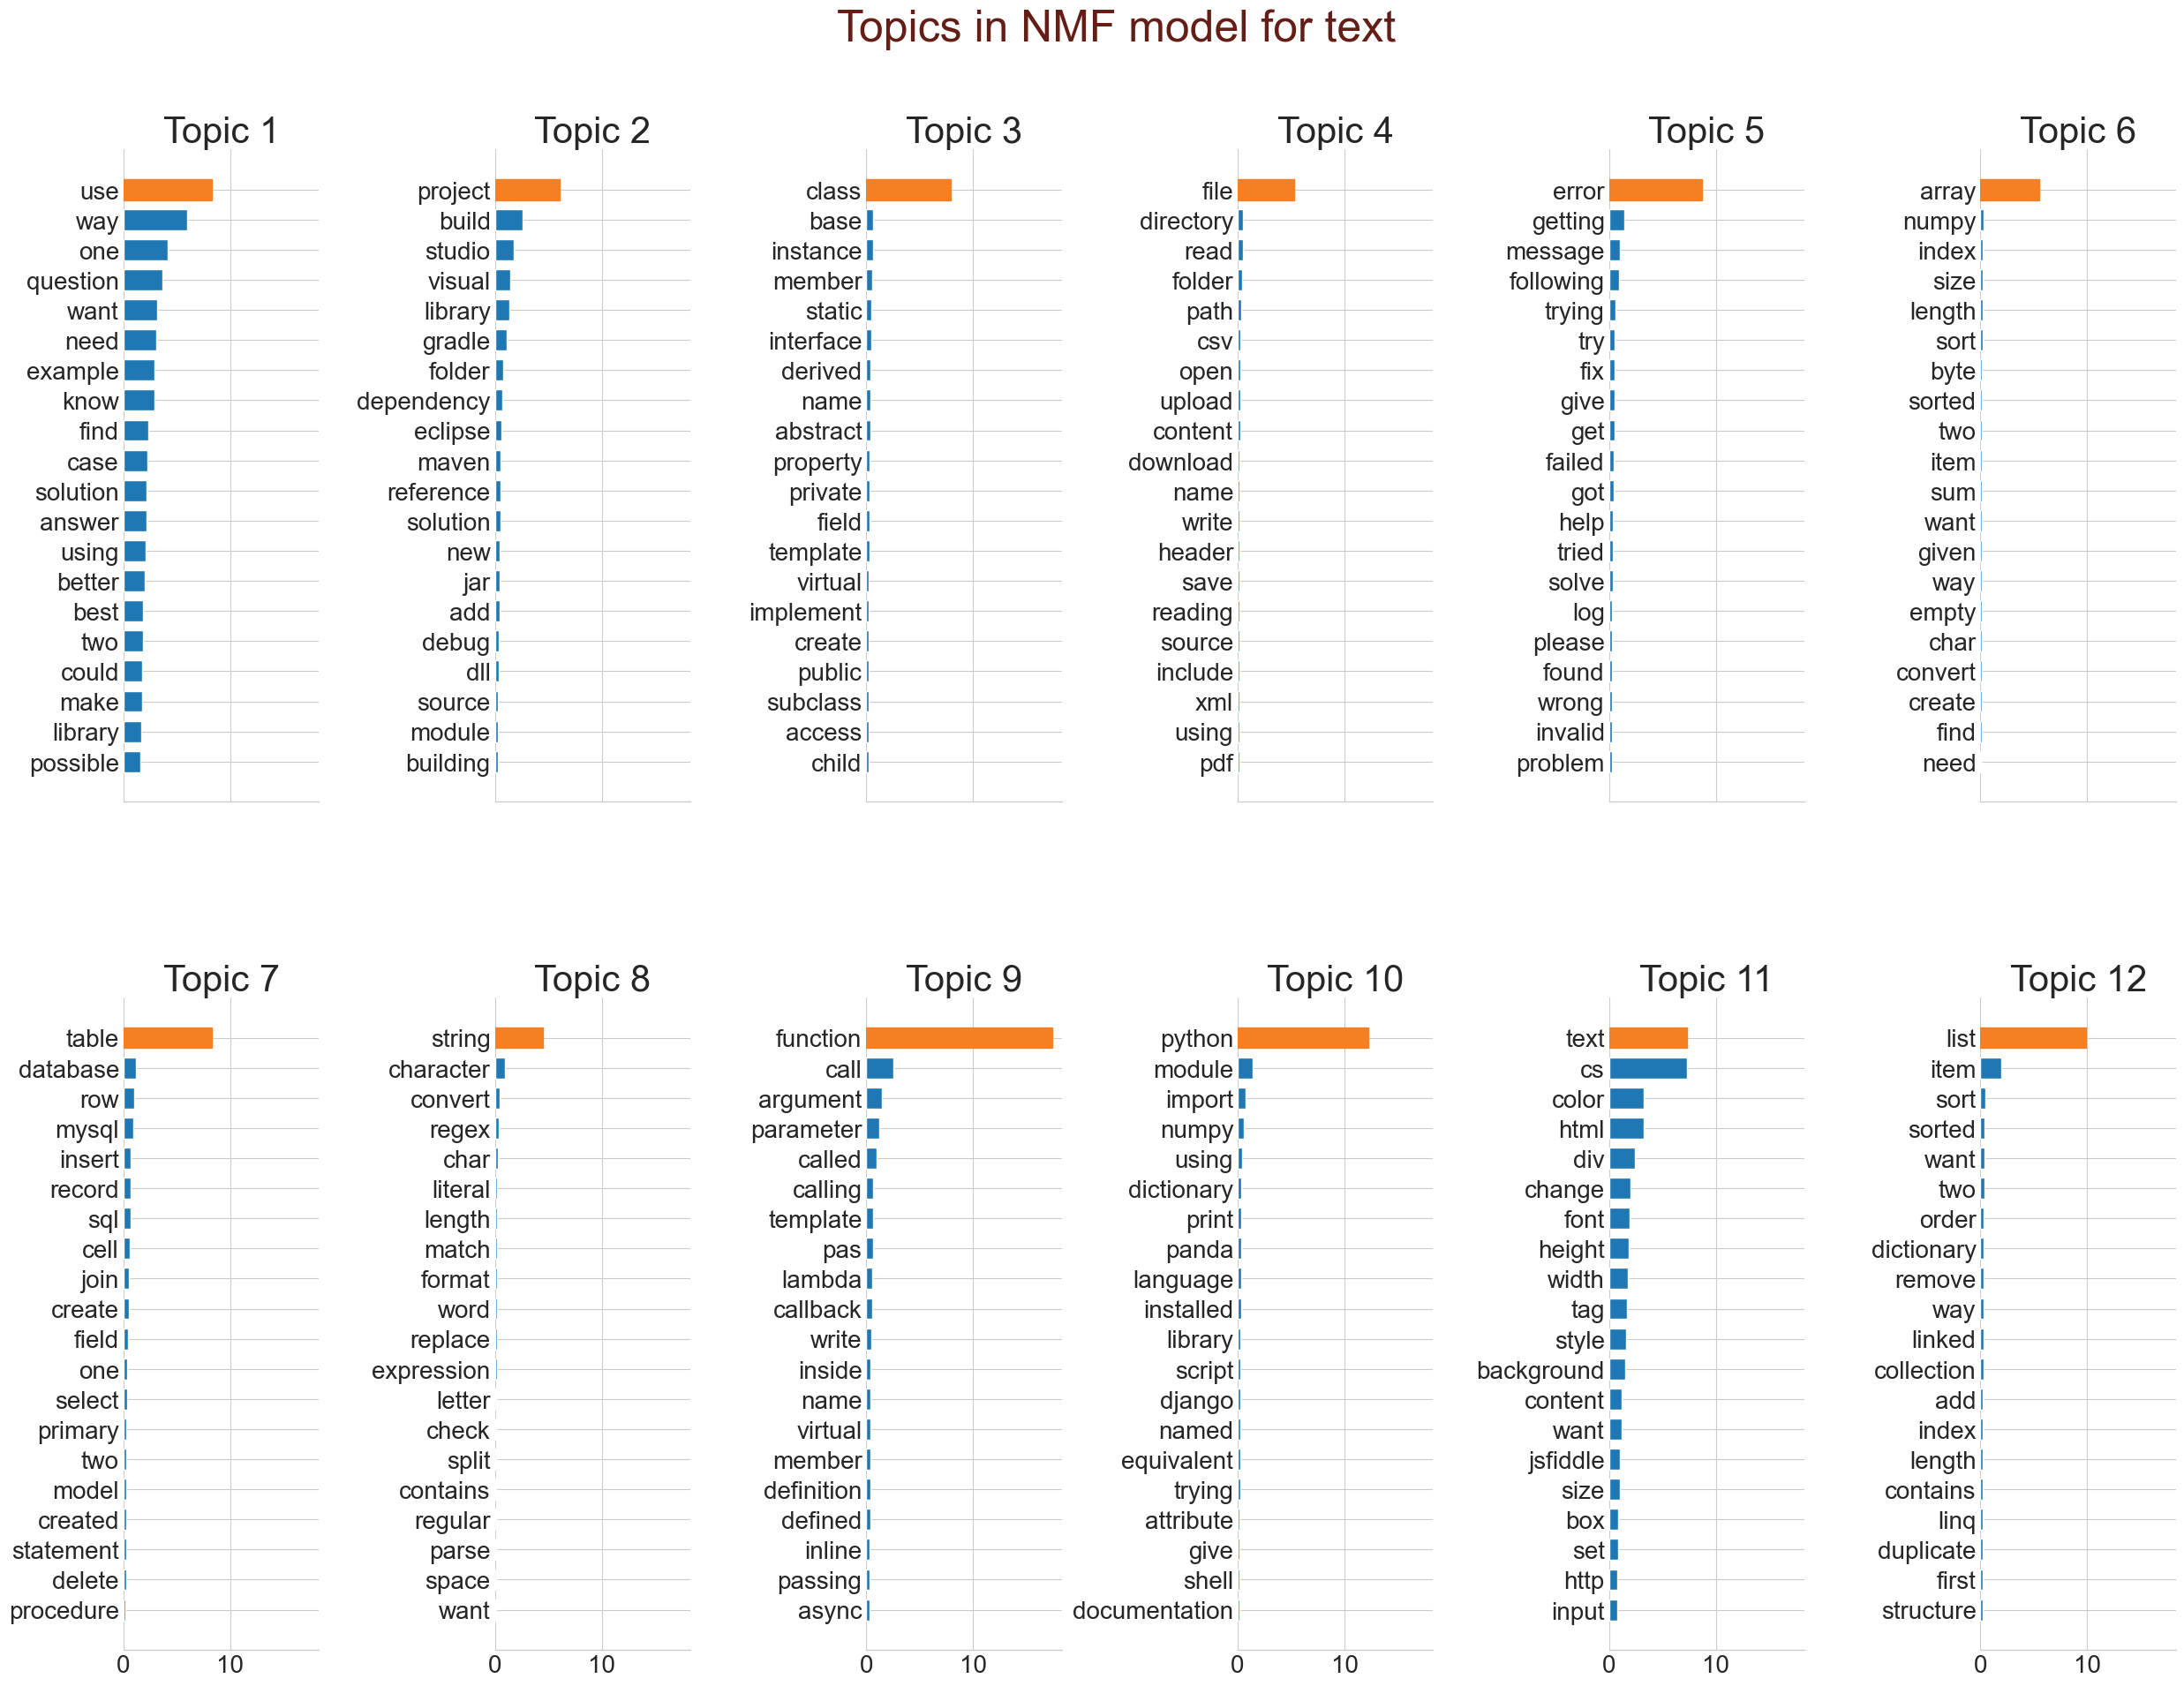

In [31]:
# Define number of topics to test
n_topics = best_nb_topics

print("-"*50)
print("Start NMF fitting on text ...")
print("-" * 50)
start_time = time.time()
# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=8)

# Fit NMF on Body vectorized
full_nmf.fit(X_tfidf)

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)

# Plot the 12 first topics
ff_feature_names = vectorizer.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 20, 12,
               'Topics in NMF model for text')

La modélisation avec NMF nous apporte des catégories aussi lisibles que celles de l'algorithme LDA. 1 mot est toujours beaucoup plus représentaif de cette catégorie mais les regroupements sont globalement cohérents. Un topic par exemple illustre bien les sujets liés SQL, aux requêtes, un second traite les sujets liés aux dictionnaires ...

En revanche, les topics générés restent très généraux et ne permettent pas une catégorisation cohérente pour notre problème d'auto-tagging. Nous allons donc tester des modèles supervisés.

#                                                   # Modèles supervisés


*
Régression logistique avec multi-labels : c'est une technique prédictive. Elle vise à construire un modèle permettant de prédire / expliquer les valeurs prises par une variable cible qualitative à partir d’un ensemble de variables explicatives quantitatives ou qualitatives encodées.


In [3]:
#on considère des métriques pour comparer les modèles de classification avec la méthode de probabilité: précision moyenne, ROC-AUC moyenne.Puis calculer le seuil optimal pour la courbe ROC pour ce type de multti_labels avec probabilité
def metrics_report(model_name ,test_labels, y_score,fit_time, df):
    """

    Compute metrics specific to multi-label
    classification problems with with ptobability

    Parameters
    ----------------------------------------
    model_name : string
        Name of the  model
    df : DataFrame
        DataFrame to accumulate result, if None : Create DataFrame.
    test_labels : array of true labels
    y_pred : array of predicted labels with ptobability
    fit_time: fit time of the model
    ----------------------------------------
    """
    if(df is not None):
        df_sc = df
    else:
        df_sc = pd.DataFrame(index=["Av_precision(macro)","Av_precision(micro)","ROC_AUC(macro)",\
                                      "ROC_AUC(micro)","Fit_time"],columns=[model_name])

    scores = []
    scores.append(average_precision_score(test_labels, y_score,average='macro'))
    scores.append(average_precision_score(test_labels, y_score,average='micro'))
    scores.append(roc_auc_score(test_labels, y_score, multi_class="ovr" ,average='macro'))
    scores.append(roc_auc_score(test_labels, y_score, multi_class="ovr" ,average='micro'))
    scores.append(fit_time)
    df_sc[model_name] = scores

    return df_sc

In [33]:
#la fonction suivante calcule le seuil des courbes ROC pour des classifications avec des proportions.

def cut_off(test_labels,y_score):
  """
  Compute threshold for predicted a probability of multi-labels

  Parameters
  ----------------------------------------
  test_labels : array of true labels
  y_score : array of predicted labels with probability
  ----------------------------------------
  """
  n = y_score.shape[1]
  thresholds = np.zeros(n)

  # Compute fpr, tpr, thresholds and roc auc
  for j in range(n):
     # calculate roc curves
     fpr, tpr, ths = roc_curve(y_test[:,j], y_score[:,j])
     # calculate the statistic
     dis = abs(1-fpr-tpr)
     # locate the index of the lower distance
     idx = np.argmin(dis)
     thresholds[j] = ths[idx]
  threshold = thresholds.max()

  return threshold

In [34]:

# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10],
              "estimator__max_iter" : [100]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)


C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10],
                         'estimator__max_iter': [100]},
             return_train_score=True, scoring='f1_weighted')

In [35]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)

logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__max_iter': 100}


In [36]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__max_iter,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,57.853918,11.247052,0.237493,0.070164,10,100,"{'estimator__C': 10, 'estimator__max_iter': 100}",0.593029,0.5937,0.59644,...,0.592703,0.0024,1,0.713726,0.711642,0.713189,0.710168,0.71037,0.711819,0.00144


Nous pouvons maintenant réaliser les prédictions avec le modèle de régression logistique sur le jeu de test pour pouvoir les comparer avec le jeu y_test.



In [37]:

time1 = time.time()
#Prediction
multi_logit_pred = multi_logit_cv.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
df_performance = metrics_report("reg_logit", y_test, multi_logit_pred, fit_time,df=None)

print(df_performance)

                     reg_logit
Av_precision(macro)   0.584413
Av_precision(micro)   0.685098
ROC_AUC(macro)        0.950982
ROC_AUC(micro)        0.965935
Fit_time              0.600000


In [38]:
#seuil de classification
cut_off(y_test,multi_logit_pred)

0.13348582412545743

In [39]:
# Inverse transform
threshold = cut_off(y_test,multi_logit_pred)
multi_logit_preds = (multi_logit_pred>threshold)*1
y_pred_inversed = multilabel_binarizer.inverse_transform(multi_logit_preds)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('mysql', 'sql'), ('android',), ('asp.net', 'asp.net-mvc', 'c#'), ('python',)]
True: [('macos',), ('mysql',), ('android',), ('asp.net',), ('python', 'python-3.x')]


In [40]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train[0:7000], y_train[0:7000])

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [41]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)

print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 5, 'estimator__min_samples_leaf': 10}


In [42]:
rfc_cv_results[rfc_cv_results["params"]==rfc_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__class_weight,param_estimator__max_depth,param_estimator__min_samples_leaf,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
2,53.342344,0.476564,7.648447,0.132813,balanced,5,10,"{'estimator__class_weight': 'balanced', 'estim...",0.508768,0.508522,0.508645,0.000123,1,0.715163,0.736769,0.725966,0.010803


In [43]:
time1 = time.time()
multi_rfc_pred = multi_rfc_cv.predict_proba(X_test)
fit_time = np.round(time.time() - time1,1)
df_performance = metrics_report("Random Forest", y_test, multi_rfc_pred,fit_time, df=df_performance)
print(df_performance)

                     reg_logit  Random Forest
Av_precision(macro)   0.584413       0.441774
Av_precision(micro)   0.685098       0.519994
ROC_AUC(macro)        0.950982       0.931440
ROC_AUC(micro)        0.965935       0.948041
Fit_time              0.600000      15.300000


In [44]:
#seuil de classification
cut_off(y_test,multi_rfc_pred)

0.48082143140929967

In [45]:
# Inverse transform
threshold = cut_off(y_test,multi_rfc_pred)
multi_rfc_preds = (multi_rfc_pred>threshold)*1
y_pred_inversed = multilabel_binarizer.inverse_transform(multi_rfc_preds)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])


--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('linux', 'php', 'python', 'windows'), ('mysql', 'performance', 'sql', 'sql-server'), ('android', 'ios', 'objective-c'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('python',)]
True: [('macos',), ('mysql',), ('android',), ('asp.net',), ('python', 'python-3.x')]


In [46]:
#Comparaison des Modèles supervisés
#Le choix du modèle supervisé final se basera essentiellement sur les scores obtenus aux métriques.
#Nous prendrons également en compte le nombre de prédiction vide est le temps de simulation.

results_perf = df_performance.T
print(results_perf)

               Av_precision(macro)  Av_precision(micro)  ROC_AUC(macro)  \
reg_logit                 0.584413             0.685098        0.950982   
Random Forest             0.441774             0.519994        0.931440   

               ROC_AUC(micro)  Fit_time  
reg_logit            0.965935       0.6  
Random Forest        0.948041      15.3  


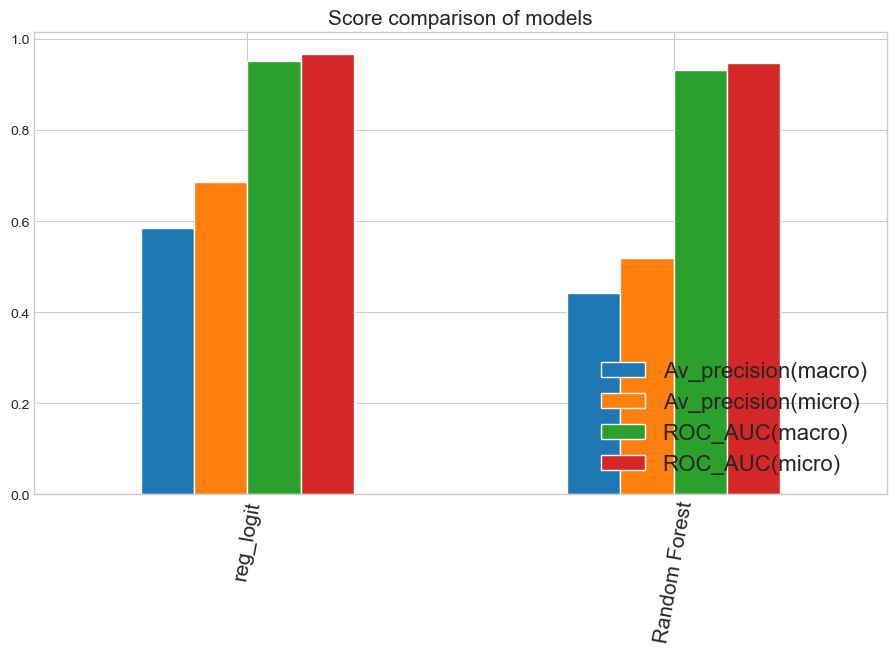

In [47]:
col_model =['Av_precision(macro)', 'Av_precision(micro)', 'ROC_AUC(macro)','ROC_AUC(micro)']
ax = results_perf[col_model].plot.bar(figsize= (11,6));
ax.legend(loc=4,fontsize=16);
ax.set_xticklabels(results_perf.index,rotation=80, fontsize=15);
ax.set_title('Score comparison of models', fontsize=15);

Nous pouvons remarquer que le modèle de régression logistique offre des meilleures précisions en vue des métriques considérées

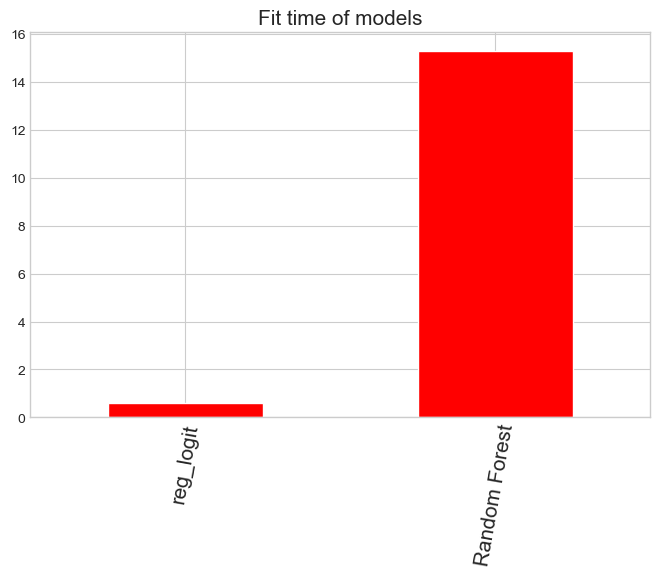

In [48]:
ax = results_perf['Fit_time'].plot.bar(figsize= (8,5),color='red');
ax.set_xticklabels(results_perf.index,rotation=80, fontsize=15);
ax.set_title('Fit time of models', fontsize=15);

# Gensim Word2Vec Implementation

Word2vec est un type de mappage qui permet à des mots ayant une signification similaire d'avoir une représentation vectorielle similaire.

Nous utilisons les features d'un modèle pré-entrainé de gensim combiné avec la régression linéaire

In [63]:
import gensim
from gensim.models import word2vec

In [64]:
model_w2v = word2vec.Word2Vec(data.text, vector_size=164, window=15, min_count=3, workers=7)
model_w2v.corpus_count

50000

In [65]:
vocab = model_w2v.wv.key_to_index
list(vocab)[:6]

['code', 'using', 'like', 'file', 'get', 'use']

In [66]:
model_w2v.wv.most_similar(['code'])

[('snippet', 0.6530637145042419),
 ('piece', 0.5817055702209473),
 ('simplified', 0.3971937596797943),
 ('shellcode', 0.3889586329460144),
 ('javaparser', 0.3880055248737335),
 ('sscce', 0.3744019865989685),
 ('sample', 0.3713977038860321),
 ('compiles', 0.3670368194580078),
 ('disassembly', 0.36416295170783997),
 ('follows', 0.3639490604400635)]

In [67]:
def document_vector(doc):
    """Create document vectors by summing word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model_w2v.wv.key_to_index]
    return np.sum(model_w2v.wv[doc], axis=0)

In [68]:
%%time
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(data.text, y_binarized, test_size=0.2, random_state=42)
#
wv_train_feat = X_train.apply(document_vector)
wv_test_feat = X_test.apply(document_vector)
#
clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
clf_lr.fit(list(wv_train_feat), y_train)
lr_pred = clf_lr.predict_proba(list(wv_test_feat))

C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mohaw\anaconda3\anacon

CPU times: total: 30min 34s
Wall time: 17min 29s


In [69]:
df_perf_wv = metrics_report("reg_logit_wv", y_test, lr_pred,255, df=None)
print(df_perf_wv)

                     reg_logit_wv
Av_precision(macro)      0.501412
Av_precision(micro)      0.633464
ROC_AUC(macro)           0.935440
ROC_AUC(micro)           0.955299
Fit_time               255.000000


Le score de la précision moyenne de la régression logistique est nettement moins que le score obtenu avec la matrice Tf-idf . Nous allons essayer de l'améliorer en jouant avec les hyperparamètres de l'apprentissage.

ou réutiliser un model pré-entrainé significativement large et impliquant un corpus similaire à notre jeu de données.

In [ ]:

# paramètres à varier size et windiw
size = [64, 128, 256, 400]
W =[5, 10, 15, 20]
sc1 = []
sc2 = []
score1 = {}
score2 = {}
for w in W:
  for s in size:

     model_w2v = word2vec.Word2Vec(data.text, vector_size=s, window=w, min_count=3, workers=7)
     wv_train_feat, wv_test_feat, y_train, y_test = train_test_split(data.text.apply(document_vector), y_binarized, test_size=0.2, random_state=42)
     clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
     clf_lr.fit(list(wv_train_feat), y_train)
     lr_pred = clf_lr.predict_proba(list(wv_test_feat))
     sc1.append(average_precision_score(y_test, lr_pred,average='macro'))
     sc2.append(roc_auc_score(y_test, lr_pred, multi_class="ovr" ,average='macro'))
  score1[w] = sc1
  score2[w] = sc2

  sc1=[]
  sc2=[]

#Nous remarquons que le paramètre de fenêtre "window" améliore nettement la précision. Cependant, le paramètre 'size' (la longeur des vecteurs des mots) à partir d'un plateau, la précision stagne voir décroît.b

C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Mohaw\anaconda3\anaconda\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Mohaw\anaconda3\anacon

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(size, score1[5], c='r')
ax1.plot(size, score1[10], c='b')
ax1.plot(size, score1[15], c='k')
ax1.plot(size, score1[20], c='m')
ax1.set_xlabel('sizes')
ax1.set_ylabel('average precision')
ax2.legend(labels = ['wind =5','wind =10','wind = 15','wind = 20'])
ax2.plot(size, score2[5], c='r')
ax2.plot(size, score2[10], c='b')
ax2.plot(size, score2[15], c='k')
ax2.plot(size, score2[20], c='m')
ax2.set_xlabel('sizes')
ax2.set_ylabel('roc_auc_score')
ax2.legend(labels = ['wind =5','wind =10','wind = 15','wind = 20']);

In [ ]:
dt = pd.DataFrame(df_performance.reg_logit).rename({'reg_logit':'reg_logit_tfidf'},axis='columns')
dt

In [ ]:
time1 = time.time()
model_w2v = word2vec.Word2Vec(data.text, vector_size=264, window=20, min_count=3, workers=7, sg=1)
wv_train_feat, wv_test_feat, y_train, y_test = train_test_split(data.text.apply(document_vector), y_binarized, test_size=0.2, random_state=42)
clf_lr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
clf_lr.fit(list(wv_train_feat), y_train)
lr_pred = clf_lr.predict_proba(list(wv_test_feat))
fit_time = np.round(time.time() - time1,1)


In [ ]:
df_perf_wv = metrics_report("reg_logit_w2v", y_test, lr_pred, fit_time, df=dt)
print(df_perf_wv)

# BERT

BERT Embeddings
BERT abréviation de Bi-directional Encoder Representations from Transformers. La famille de modèles BERT utilise l'architecture de l'encodeur Transformer pour traiter chaque jeton de texte d'entrée dans le contexte complet de tous les jetons avant et après, d'où le nom : Représentations d'encodeur bidirectionnel de Transformers.

Les modèles BERT sont généralement pré-formés sur un grand corpus de texte, puis affinés pour des tâches spécifiques.

5.1 BERT hub Tensorflow
Installation des transformeurs et tensorflow-text pour bert. Nous utilisons un GPU comme le calcul des features demande un effort important.

In [67]:
pip install transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.8 MB/s eta 0:00:00


In [72]:
!pip install tensorflow

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
!pip install --upgrade tensorflow_hub

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
pip install -q -U tensorflow-text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 557.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 19.5 MB/s eta 0:00:00


In [73]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.*

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
dt =data.copy()
dt.text = dt.text.apply(lambda text : " ".join(text))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2"
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
#pour de raison de mémoire, la fonction suivante construit la matrice des features de Bert morceau par morceau

def feature_bert_tfh(sentences, key, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        inputs = preprocess(sentences[idx:idx+batch_size])
        feat = bert(inputs)[key]

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    if idx+batch_size<len(sentences):
       inputs = preprocess(sentences[idx+batch_size:len(sentences)])
       feat = bert(inputs)[key]
       features = np.concatenate((features,feat))

    return features


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
#Régression logistique combinée avec les features de Bert

reg_logit_clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
time1=time.time()
feat_bert = feature_bert_tfh(dt.text, 'pooled_output',128)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
# split features
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(feat_bert, y_binarized, test_size=0.25)
reg_logit_clf.fit(Bertfet_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [80]:
#Prediction
bert_plr = reg_logit_clf.predict_proba(Bertfet_test)
fit_time = np.round(time.time() - time1,1)

df_perf_brt_tfh = metrics_report("reg_log_bert_tfhub", y_test, bert_plr,fit_time, df=df_perf_wv)
print(df_perf_brt_tfh)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                     reg_logit_wv  reg_log_bert_tfhub
Av_precision(macro)      0.393440            0.262914
Av_precision(micro)      0.539780            0.333056
ROC_AUC(macro)           0.892398            0.827572
ROC_AUC(micro)           0.928858            0.875648
Fit_time               255.000000         3189.100000


In [81]:
#Le score de la régression logistique avec Bert est nettement moins bon que le score obtenu avec la matrice Tf-idf. Il faut réutiliser un autre model pré-entrainé significativement large et impliquant un corpus similaire à notre jeu de données.

#U sentence-transformers
#SentenceTransformer('all-MiniLM-L6-v2') Il s'agit d'un modèle de transformation de phrases qui représente les phrases avec des vecteurs denses de 384 dimensions.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
# install -U sentence-transformers
!pip install -U sentence-transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=f9b79108f5a56950e5f4961cfd6e909e7d10cb9e61a815d750f5911dfea1f4c3
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [83]:
from sentence_transformers import SentenceTransformer
#download a pretrained model
model_bert = SentenceTransformer('all-MiniLM-L6-v2')
#model_bert = SentenceTransformer('all-mpnet-base-v2')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
def feature_bert_ST(sentences, b_size) :
    batch_size = b_size
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = model_bert.encode(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))


    if idx+batch_size<len(sentences):

       features = np.concatenate(features,model_bert.encode(sentences[idx+batch_size:len(sentences)]))

    return features


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
#Régression logistique combinée avec les features de Bert 'all-MiniLM-L6-v2'.
sentence_embeddings = []
for key in dt.text.keys():
    try:
        embedding = model_bert.encode(dt.text[key])
        sentence_embeddings.append(embedding)
    except KeyError:
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
%%time
batch_size = 64
# split features
time1 = time.time()
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(sentence_embeddings, y_binarized, test_size=0.25)
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
reg_logit_clf.fit(Bertfet_train, y_train)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 5.3 s, sys: 1.58 s, total: 6.88 s
Wall time: 3.57 s


OneVsRestClassifier(estimator=LogisticRegression())

In [87]:
#Prediction
bert_pred_lr = reg_logit_clf.predict_proba(Bertfet_test)

fit_time = np.round(time.time() - time1,1)
df_perf_brt_ST = metrics_report("df_perf_brt_ST", y_test, bert_pred_lr, fit_time, df=df_perf_brt_tfh)
print(df_perf_brt_ST)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                     reg_logit_wv  reg_log_bert_tfhub  df_perf_brt_ST
Av_precision(macro)      0.393440            0.262914        0.625293
Av_precision(micro)      0.539780            0.333056        0.722382
ROC_AUC(macro)           0.892398            0.827572        0.967694
ROC_AUC(micro)           0.928858            0.875648        0.976811
Fit_time               255.000000         3189.100000      517.900000


Universal Sentence Encoder
Le score de la régression logistique avec Bert est nettement moins bon que le score obtenu avec la matrice Tf-idf. Il faut réutiliser un autre model pré-entrainé significativement large et impliquant un corpus similaire à notre jeu de données.

In [88]:
#First download a pretrained model
Model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
def feature_USE(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = Model_use(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))



    if idx+batch_size<len(sentences):
       feat = Model_use(sentences[idx+batch_size:len(sentences)])
       features = np.concatenate((features,feat))

    return features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
%%time
time1 = time.time()
batch_size = 64
use_features = feature_USE(dt.text, batch_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4.28 s, sys: 90.3 ms, total: 4.37 s
Wall time: 3.6 s


In [92]:
# split features
usefet_train, usefet_test, y_train, y_test = train_test_split(use_features, y_binarized, test_size=0.25)
reg_logit_clf = OneVsRestClassifier(LogisticRegression())
reg_logit_clf.fit(usefet_train, y_train)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OneVsRestClassifier(estimator=LogisticRegression())

In [93]:
#Prediction
usepred_lr = reg_logit_clf.predict_proba(usefet_test)

fit_time = np.round(time.time() - time1,1)
df_perf_use = metrics_report("reg_logit with use", y_test, usepred_lr, fit_time, df=df_perf_brt_ST)
print(df_perf_use)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                     reg_logit_wv  reg_log_bert_tfhub  df_perf_brt_ST  \
Av_precision(macro)      0.393440            0.262914        0.625293   
Av_precision(micro)      0.539780            0.333056        0.722382   
ROC_AUC(macro)           0.892398            0.827572        0.967694   
ROC_AUC(micro)           0.928858            0.875648        0.976811   
Fit_time               255.000000         3189.100000      517.900000   

                     reg_logit with use  
Av_precision(macro)            0.580287  
Av_precision(micro)            0.673921  
ROC_AUC(macro)                 0.968519  
ROC_AUC(micro)                 0.973661  
Fit_time                      23.500000  


In [27]:
import pandas as pd
df_result = pandas.DataFrame({'Av_precision(macro)': [0.393440, 0.262914, 0.625293, 0.580287], 'Av_precision(micro)':[0.928858, 0.875648, 0.976811, 0.973661], 'ROC_AUC(macro)': [0.892398, 0.827572, 0.967694, 0.968519], 'ROC_AUC(micro)': [0.539780, 0.333056, 0.722382, 0.673921], 'Fit_time': [255.000000, 3189.100000, 517.900000, 23.500000]},
                      index = ['reg_logit_wv', 'reg_log_bert_tfhub', 'df_perf_brt_ST', 'reg_logit with use'])
df_result

,Av_precision(macro),Av_precision(micro),ROC_AUC(macro),ROC_AUC(micro),Fit_time
reg_logit_wv,0.393440,0.928858,0.892398,0.539780,255.0
reg_log_bert_tfhub,0.262914,0.875648,0.827572,0.333056,3189.1
df_perf_brt_ST,0.625293,0.976811,0.967694,0.722382,517.9
reg_logit with use,0.580287,0.973661,0.968519,0.673921,23.5


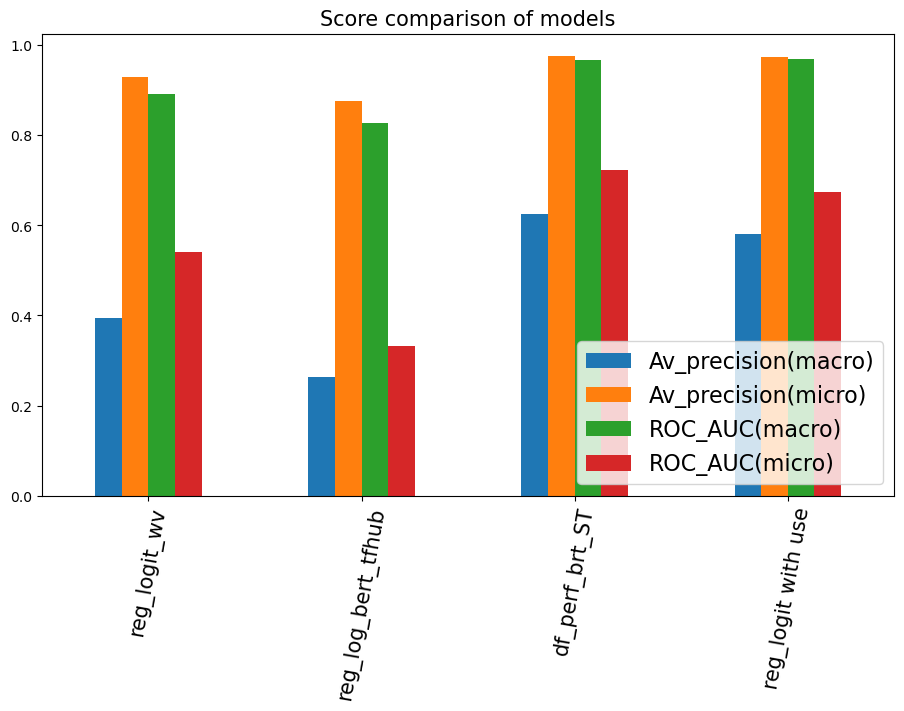

In [32]:
col_model =['Av_precision(macro)', 'Av_precision(micro)', 'ROC_AUC(macro)','ROC_AUC(micro)']
ax = df_result[col_model].plot.bar(figsize= (11,6));
ax.legend(loc=4,fontsize=16);
ax.set_xticklabels(df_result.index,rotation=80, fontsize=15);
ax.set_title('Score comparison of models', fontsize=15);

Text(0.5, 1.0, 'Fit time of Embeddings features with logisticregression')

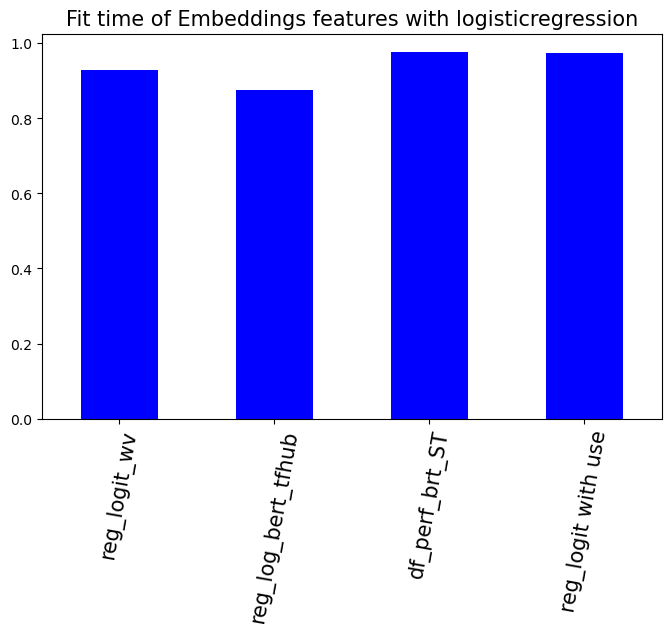

In [31]:
ax = df_result['Av_precision(micro)'].plot.bar(figsize= (8,5),color='blue');
ax.set_xticklabels(df_perf_use.index,rotation=80, fontsize=15);
ax.set_title('Fit time of Embeddings features with logisticregression', fontsize=15)

Le score de la régression logistique avec U sentence-transformers et USE est nettement proche supérieurement du score obtenu avec la matrice Tf-idf. Cependant même avec GPU le temps de calcul est beaucoup important en comparaison avec la matrice Tf-idf.